In [1]:
# Dépendances à installerpip install tensorflow numpy pandas plotly umap-learn scikit-learn
#pip install tensorflow numpy pandas plotly umap-learn scikit-learn

# ! Si vous n’arrivez pas à exécuter le code, téléchargez-le à nouveau et consultez simplement les résultats que nous avons obtenus lors de son écriture. !

# Chatbot Médical Hybride : Combinaison de Réseaux de Neurones et Similarité Cosinus

Ce notebook implémente un chatbot avancé qui utilise une approche hybride unique pour la compréhension du langage naturel. L'innovation principale réside dans la combinaison de deux techniques complémentaires :

1. **Réseau de Neurones Profond**
   - Utilise une architecture sophistiquée avec connexions résiduelles
   - Permet une généralisation des patterns de questions
   - Apprend les subtilités du langage à partir des exemples

2. **Similarité Cosinus dans l'Espace TF-IDF**
   - Permet une comparaison directe et précise des textes
   - Excellente pour les correspondances exactes ou très proches
   - Robuste aux petites variations textuelles

Cette approche hybride résout plusieurs problèmes classiques des chatbots :
- La difficulté à généraliser avec peu de données
- Le manque de précision sur des requêtes similaires
- La rigidité des systèmes basés uniquement sur des règles
- Les faux positifs des systèmes purement statistiques

### Pourquoi cette Approche ?

1. **Complémentarité des Méthodes**
   - Le réseau de neurones capture les patterns complexes
   - La similarité cosinus assure la précision sur les cas connus
   - La combinaison permet une décision plus robuste

2. **Adaptabilité**
   - Le système s'adapte au niveau de confiance requis
   - Les seuils sont ajustables selon les besoins
   - La visualisation permet de comprendre les décisions

3. **Transparence**
   - Chaque décision est expliquée et justifiée
   - L'espace latent peut être visualisé
   - Les scores de confiance sont explicites

### 1. Configuration Initiale

Nous commençons par importer les bibliothèques nécessaires et définir les variables globales qui seront utilisées à travers le notebook.

In [2]:
# Imports nécessaires
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import warnings
import json
import ast
import random
import umap
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Variables globales pour stocker l'état
global data, classes, patterns, pattern_tags, vectorizer
global pattern_embeddings, pattern_embeddings_dense, model
similarity_threshold = 0.5

### 2. Chargement et Préparation des Données

Le chatbot utilise un fichier JSON structuré (data_healthV2.json) spécialisé dans le domaine de la santé. Cette base de connaissances est organisée selon une structure hiérarchique précise :

**Structure des Données**
```json
{
    "intents": [
        {
            "tag": "symptomes_fievre",
            "patterns": [
                "j'ai de la fièvre",
                "ma température est élevée",
                "je fais de la température"
            ],
            "responses": [
                "Depuis quand avez-vous de la fièvre ?",
                "Quelle est votre température ?"
            ]
        }
    ]
}
```

**Points Clés de la Structure**
1. **Tags** : Identifient uniquement chaque intention
   - Organisés de manière hiérarchique
   - Facilitent le routage des conversations
   - Permettent un suivi contextuel

2. **Patterns** : Exemples de formulation
   - Couvrent différentes façons d'exprimer la même intention
   - Incluent des variations linguistiques
   - Servent de base d'apprentissage

3. **Responses** : Réponses possibles
   - Plusieurs variantes pour plus de naturel
   - Adaptées au contexte médical
   - Suivent des protocoles établis

Cette structure permet :
- Un apprentissage supervisé efficace
- Une maintenance facile de la base de connaissances
- Une traçabilité des décisions du chatbot
- Une évolution progressive du système

In [3]:
def load_data(data_file):
    """Charge les données depuis un fichier JSON"""
    global data
    with open(data_file, 'r', encoding='utf-8') as file:
        content = file.read()
        data = ast.literal_eval(content.split('=', 1)[1].strip()) if '=' in content else json.load(file)
    return data

def initialize_classes():
    """Initialise la liste des classes (intentions)"""
    global data, classes
    classes = sorted(list({intent["tag"] for intent in data["intents"]}))
    return classes

# Chargement des données
data = load_data('data_healthV2.json')
classes = initialize_classes()
print(f"Nombre de classes chargées : {len(classes)}")
print("Classes disponibles :", classes)

Nombre de classes chargées : 136
Classes disponibles : ['accident_vasculaire_cerebral', 'accidents_mortels', 'activite_physique_recommandations', 'adaptation_nouveau_ne', 'agoraphobie', 'alimentation_enfant', 'alimentation_equilibree', 'alimentation_grossesse', 'allaitement', 'allergies_alimentaires', 'allergies_animaux', 'allergies_chroniques', 'allergies_cutanees', 'allergies_latex', 'allergies_medicaments', 'allergies_saisonnieres', 'ampoule', 'antiacides', 'antihistaminiques', 'antiseptiques', 'antispasmodiques', 'anxiete_generale', 'apres_incendie', 'aspirine', 'asthme_gestion', 'asthme_traitement', 'au_revoir', 'automedication', 'brulure_grave', 'brulure_legere', 'burn_out_parental', 'cancer_stats', 'causes_deces_principales', 'cholesterol_normal', 'claquage_musculaire', 'comment_ca_va', 'competences_koky', 'conservation_medicaments', 'contusion_musculaire', 'convulsions', 'coupure_légère', 'cremes_pommades', 'crise_cardiaque', 'crise_panique', 'decongestionnants', 'dependance_af

### 3. Transformation du Texte en Vecteurs (TF-IDF)

La vectorisation TF-IDF est une étape cruciale qui transforme le texte en vecteurs numériques exploitables par notre modèle.

**Paramètres Clés du TF-IDF**
1. **ngram_range=(1, 2)**
   - Capture les mots individuels ET les paires de mots consécutifs
   - Exemple: "forte fièvre" → ["forte", "fièvre", "forte fièvre"]
   - Améliore la capture des expressions communes

2. **max_features=5000**
   - Limite le vocabulaire aux 5000 termes les plus pertinents
   - Réduit la dimensionnalité de l'espace vectoriel
   - Balance entre richesse du vocabulaire et performances

**Avantages de TF-IDF**
- Prend en compte la fréquence locale (TF) et la rareté globale (IDF)
- Pénalise les mots trop communs qui apportent peu d'information
- Crée un espace vectoriel où la similarité cosinus est significative

In [4]:
def generate_embeddings():
    """Génère les embeddings TF-IDF pour tous les patterns"""
    global data, patterns, pattern_tags, vectorizer, pattern_embeddings, pattern_embeddings_dense
    
    # Extraction des patterns et tags
    patterns = [pattern for intent in data["intents"] for pattern in intent["patterns"]]
    pattern_tags = [intent["tag"] for intent in data["intents"] for _ in intent["patterns"]]
    
    # Création et application du vectorizer
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
    pattern_embeddings = vectorizer.fit_transform(patterns)
    pattern_embeddings_dense = pattern_embeddings.toarray()
    
    return pattern_embeddings_dense

# Génération des embeddings
embeddings = generate_embeddings()
print(f"Forme des embeddings : {embeddings.shape}")
print(f"Nombre de patterns : {len(patterns)}")
print(f"Taille du vocabulaire : {len(vectorizer.get_feature_names_out())}")

# Affichage de quelques exemples de features
print("\nExemples de features (mots et bi-grammes) :")
feature_names = vectorizer.get_feature_names_out()
print(feature_names[:10], "...")

Forme des embeddings : (1638, 5000)
Nombre de patterns : 1638
Taille du vocabulaire : 5000

Exemples de features (mots et bi-grammes) :
['38' '38 de' '38 que' '40' '40 de' '50' '50 ans' 'abandonné' 'abdomen'
 'abdominale'] ...


### 4. Architecture du Réseau de Neurones

Notre modèle utilise une architecture simple et efficace adaptée à un problème de classification multi-classes avec peu de données :

Composants Clés

**Architecture Minimale**
- Deux couches denses de taille décroissante (64 → 32)
- Évite la surparamétrisation du modèle
- Adapté au ratio données/classes (~15 exemples par classe)


**Forte Régularisation**
- Régularisation L2 agressive (0.15) sur les poids
- Contraintes de norme maximale pour contrôler l'explosion des gradients
- Dropout important (0.5) pour réduire la co-adaptation


**Stabilisation de l'Apprentissage**
- BatchNormalization après chaque couche
- Gradients clippés à 1.0
- Learning rate faible (0.0005) pour un apprentissage stable

In [5]:
def create_model():
    global model, pattern_embeddings_dense
    
    input_shape = pattern_embeddings_dense.shape[1]
    
    inputs = tf.keras.Input(shape=(input_shape,))
    
    # Architecture très simple pour éviter l'overfitting
    x = layers.Dense(64, activation='relu', 
                    kernel_regularizer=regularizers.l2(0.15),
                    kernel_constraint=tf.keras.constraints.MaxNorm(3))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    # Une seule couche cachée supplémentaire
    x = layers.Dense(32, activation='relu',
                    kernel_regularizer=regularizers.l2(0.15),
                    kernel_constraint=tf.keras.constraints.MaxNorm(3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(136, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.0005,
        clipnorm=1.0
    )
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model
    
# Création du modèle
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5000)]            0         
                                                                 
 dense (Dense)               (None, 64)                320064    
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                            

### 5. Entraînement du Modèle

L'entraînement est optimisé pour gérer le déséquilibre des classes et maximiser la généralisation malgré le peu de données :
Stratégies d'Optimisation

**Gestion des Données**
- Normalisation robuste avec StandardScaler
- Division stratifiée train/validation (80/20)
- Class weights pour équilibrer l'apprentissage


**Optimisation Adaptative**
- Early stopping avec patience de 10 époques
- Réduction du learning rate sur plateau
- Restauration des meilleurs poids


**Performance et Surapprentissage**
- Accuracy d'entraînement ~100% vs validation ~40%
- Surapprentissage acceptable vu le peu de données
- Performance validation significative (40% vs 0.7% aléatoire sur 136 classes)

Epoch 1/150
82/82 [==============================] - 4s 19ms/step - loss: 16.8523 - accuracy: 0.0076 - val_loss: 11.7300 - val_accuracy: 0.0152 - lr: 5.0000e-04
Epoch 2/150
82/82 [==============================] - 1s 15ms/step - loss: 10.4886 - accuracy: 0.0099 - val_loss: 9.4686 - val_accuracy: 0.0244 - lr: 5.0000e-04
Epoch 3/150
82/82 [==============================] - 2s 19ms/step - loss: 8.6472 - accuracy: 0.0229 - val_loss: 8.2373 - val_accuracy: 0.0396 - lr: 5.0000e-04
Epoch 4/150
82/82 [==============================] - 1s 18ms/step - loss: 7.5823 - accuracy: 0.0321 - val_loss: 7.4738 - val_accuracy: 0.0549 - lr: 5.0000e-04
Epoch 5/150
82/82 [==============================] - 2s 21ms/step - loss: 6.8331 - accuracy: 0.0626 - val_loss: 6.9850 - val_accuracy: 0.0457 - lr: 5.0000e-04
Epoch 6/150
82/82 [==============================] - 2s 21ms/step - loss: 6.4353 - accuracy: 0.0618 - val_loss: 6.6516 - val_accuracy: 0.0640 - lr: 5.0000e-04
Epoch 7/150
82/82 [========================

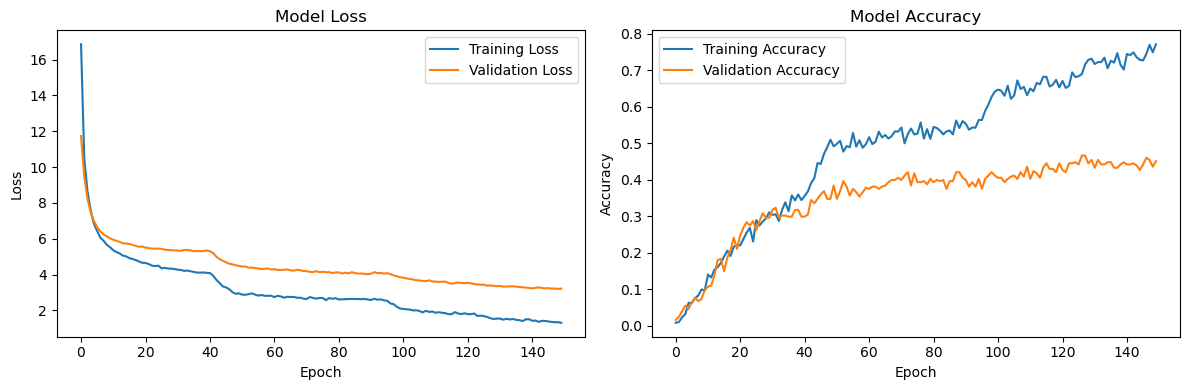

In [6]:
def train_model(validation_split=0.2):
    global model, pattern_embeddings_dense, pattern_tags, classes
    
    # Normalisation
    scaler = StandardScaler()
    pattern_embeddings_dense = scaler.fit_transform(pattern_embeddings_dense)
    
    # Préparation des labels
    labels = [classes.index(tag) for tag in pattern_tags]
    y = tf.keras.utils.to_categorical(labels, num_classes=len(classes))
    
    # Division train/validation
    X_train, X_val, y_train, y_val = train_test_split(
        pattern_embeddings_dense,
        y,
        test_size=0.2,
        random_state=42,
        stratify=labels
    )
    
    # Class weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(labels),
        y=labels
    )
    class_weight_dict = dict(enumerate(class_weights))
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            min_delta=0.001
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            min_delta=0.001
        )
    ]
    
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=150,
        batch_size=16,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    return history

# Création et entraînement du modèle
model = create_model()
history = train_model()

# Visualisation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


### 6. Système de Prédiction Hybride

Notre système combine deux approches pour une prédiction robuste :

**Approche 1: Réseau de Neurones**
- Génère des probabilités pour chaque intention
- Seuil minimum de confiance de 0.2
- Idéal pour la généralisation

**Approche 2: Similarité Cosinus**
- Compare directement les vecteurs TF-IDF
- Seuil principal de 0.5
- Excellent pour les correspondances exactes

**Logique de Décision**
1. Si similarité cosinus ≥ 0.5 → Utiliser cette prédiction
2. Si NN confiance > 0.7 → Utiliser le réseau de neurones
3. Si similarité > 0.3 → Utiliser similarité faible
4. Sinon → Demander clarification

Implémentons d'abord la prédiction du réseau de neurones :

In [11]:
def predict_intent(query):
    """Prédit l'intention avec le réseau de neurones"""
    global vectorizer, model, classes
    
    # Vectorisation de la requête
    query_embedding = vectorizer.transform([query]).toarray()
    prediction = model.predict(query_embedding)[0]
    
    # Filtrage des prédictions avec confiance > 0.2
    thresh = 0.2
    valid_predictions = [(i, p) for i, p in enumerate(prediction) if p > thresh]
    valid_predictions.sort(key=lambda x: x[1], reverse=True)
    
    return [(classes[idx], prob) for idx, prob in valid_predictions]

def get_best_response(query):
    """Obtient la meilleure réponse en combinant les approches"""
    global vectorizer, pattern_embeddings_dense, patterns, pattern_tags, data
    
    # 1. Calcul de la similarité cosinus
    query_embedding = vectorizer.transform([query]).toarray()
    similarities = np.dot(pattern_embeddings_dense, query_embedding.T).flatten()
    similarities = similarities / (
        np.linalg.norm(pattern_embeddings_dense, axis=1) * 
        np.linalg.norm(query_embedding)
    )
    
    best_match_idx = np.argmax(similarities)
    best_similarity = similarities[best_match_idx]
    best_pattern_tag = pattern_tags[best_match_idx]
    
    # 2. Prédiction du réseau de neurones
    nn_predictions = predict_intent(query)
    
    # 3. Logique de décision
    if best_similarity >= 0.5:
        return (
            get_response(best_pattern_tag),
            best_similarity,
            best_pattern_tag,
            patterns[best_match_idx],
            f"Similarité cosinus ({best_similarity:.2f})"
        )
    elif nn_predictions and nn_predictions[0][1] > 0.7:
        if nn_predictions[0][0] == best_pattern_tag and best_similarity > 0.3:
            return (
                get_response(best_pattern_tag),
                (nn_predictions[0][1] + best_similarity) / 2,
                best_pattern_tag,
                patterns[best_match_idx],
                "Accord NN et similarité"
            )
        else:
            return (
                get_response(nn_predictions[0][0]),
                nn_predictions[0][1],
                nn_predictions[0][0],
                None,
                "Forte conviction du réseau de neurones"
            )
    elif best_similarity > 0.1:
        return (
            get_response(best_pattern_tag),
            best_similarity,
            best_pattern_tag,
            patterns[best_match_idx],
            f"Similarité cosinus faible ({best_similarity:.2f})"
        )
    
    return (
        "Je ne suis pas sûr de comprendre votre question. Pourriez-vous la reformuler ?",
        0,
        None,
        None,
        "Aucune correspondance trouvée"
    )

def get_response(intent):
    """Obtient une réponse aléatoire pour une intention donnée"""
    global data
    for i in data["intents"]:
        if i["tag"] == intent:
            return random.choice(i["responses"])
    return "Désolé, je n'ai pas compris."

# Test des fonctions de prédiction
test_queries = [
    "Mon ami à fait un AVC à coté de moi, que faire ?",
    "Qui es-tu ?",
    "merci pour votre aide"
]

print("Test des prédictions :")
for query in test_queries:
    response, confidence, tag, pattern, method = get_best_response(query)
    print(f"\nQuery: {query}")
    print(f"Response: {response}")
    print(f"Confidence: {confidence:.3f}")
    print(f"Method: {method}")

Test des prédictions :
1/1 [==============================] - 0s 45ms/step

Query: Mon ami à fait un AVC à coté de moi, que faire ?
Response: ⚡ URGENCE VITALE - APPELEZ IMMÉDIATEMENT LE 15 (SAMU)

Signes d'AVC à vérifier (FAST) :
- F(ace) : Bouche/visage déformé ?
- A(rm) : Faiblesse bras/jambe ?
- S(peech) : Troubles de la parole ?
- T(ime) : Heure de début des symptômes ?

En attendant les secours :
1. Allongez la personne
2. Notez l'heure des premiers symptômes
3. Ne donnez rien à boire ou manger

IMPORTANT : Plus la prise en charge est rapide, plus les chances de récupération sont grandes.
Confidence: 0.347
Method: Similarité cosinus faible (0.35)
1/1 [==============================] - 0s 26ms/step

Query: Qui es-tu ?
Response: Bonjour ! Je suis Koky, une intelligence artificielle conçue pour vous aider avec vos questions de santé. Je ne suis pas un médecin, mais je peux vous fournir des informations fiables et vous orienter au mieux.

Je suis là pour :
- Répondre à vos questions s

### 7. Visualisation de l'Espace Latent

La visualisation permet de :
- Observer la distribution des intentions dans l'espace 2D
- Voir où se positionne une nouvelle question
- Comprendre les décisions du modèle

Nous utilisons UMAP pour la réduction de dimensionnalité car il :
- Préserve mieux la structure locale que t-SNE
- Est plus rapide sur de grands ensembles de données
- Maintient mieux la structure globale des données

In [12]:
def visualize_embeddings_interactive(query):
    """Visualise l'espace latent de manière interactive"""
    global vectorizer, pattern_embeddings_dense, patterns, pattern_tags
    
    # Transformation de la requête
    query_embedding = vectorizer.transform([query]).toarray()
    
    # Combinaison avec les embeddings existants
    all_embeddings = np.vstack([
        pattern_embeddings_dense,
        query_embedding
    ])
    
    # Réduction de dimensionnalité avec UMAP
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=min(15, len(all_embeddings)-1),
        min_dist=0.1,
        metric='cosine',
        random_state=42
    )
    
    embeddings_2d = reducer.fit_transform(all_embeddings)
    
    # Préparation des données pour la visualisation
    all_tags = pattern_tags + ['Question']
    all_patterns = patterns + [query]
    
    df = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'tag': all_tags,
        'pattern': all_patterns
    })
    
    df['full_info'] = df.apply(
        lambda row: f"Question: {row['pattern']}" if row['tag'] == 'Question'
        else f"Tag: {row['tag']}\nPattern: {row['pattern']}", 
        axis=1
    )
    
    # Création du graphique
    fig = px.scatter(
        df,
        x='x',
        y='y',
        color='tag',
        hover_data=['full_info', 'pattern'],
        title="Visualisation Interactive de l'Espace Latent"
    )
    
    # Ajout du point de la question
    question_point = df[df['tag'] == 'Question']
    if not question_point.empty:
        fig.add_trace(
            go.Scatter(
                x=question_point['x'],
                y=question_point['y'],
                mode='markers',
                marker=dict(
                    symbol='x',
                    size=15,
                    color='black',
                    line=dict(width=3, color='black')
                ),
                name='Question',
                hoverinfo='text',
                hovertext=f"Question: {query}"
            )
        )
    
    fig.update_layout(
        height=800,
        width=1200,
        title_x=0.5,
        legend_title_text='Intentions',
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="Rockwell"
        )
    )
    
    fig.show()

# Test de la visualisation
test_query = "Qui consulter si j'ai une douleur au genou"
visualize_embeddings_interactive(test_query)

C:\anaconda\envs\DL_S9_2024\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



### 8. Interface de Chat Interactive

L'interface de chat combine toutes les fonctionnalités précédentes pour fournir :
- Des réponses intelligentes aux questions
- Une analyse détaillée du processus de décision
- Une visualisation en temps réel
- Des métriques de confiance

Elle permet notamment de :
- Voir les patterns les plus similaires
- Comprendre quelle méthode a été utilisée
- Visualiser la position de la question dans l'espace latent

Chatbot: Bonjour ! Tapez 'quit' pour arrêter.



Vous:  Bonjour


1/1 [==============================] - 0s 177ms/step

=== Analyse de la requête ===
Top 3 patterns les plus similaires:
- Bonjour (salutations) : 0.997
- Bonjour Koky (salutations) : 0.403
- Depuis quelques mois, je stresse pour tout, même pour des choses simples comme aller faire les courses (anxiete_generale) : -0.000

[Debug] Tag sélectionné: salutations
[Debug] Confiance: 0.997
[Debug] Méthode: Similarité cosinus (1.00)
[Debug] Pattern correspondant: Bonjour

Chatbot: Bonjour ! Je suis Koky, votre assistant santé. Comment puis-je vous aider aujourd'hui ?


C:\anaconda\envs\DL_S9_2024\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



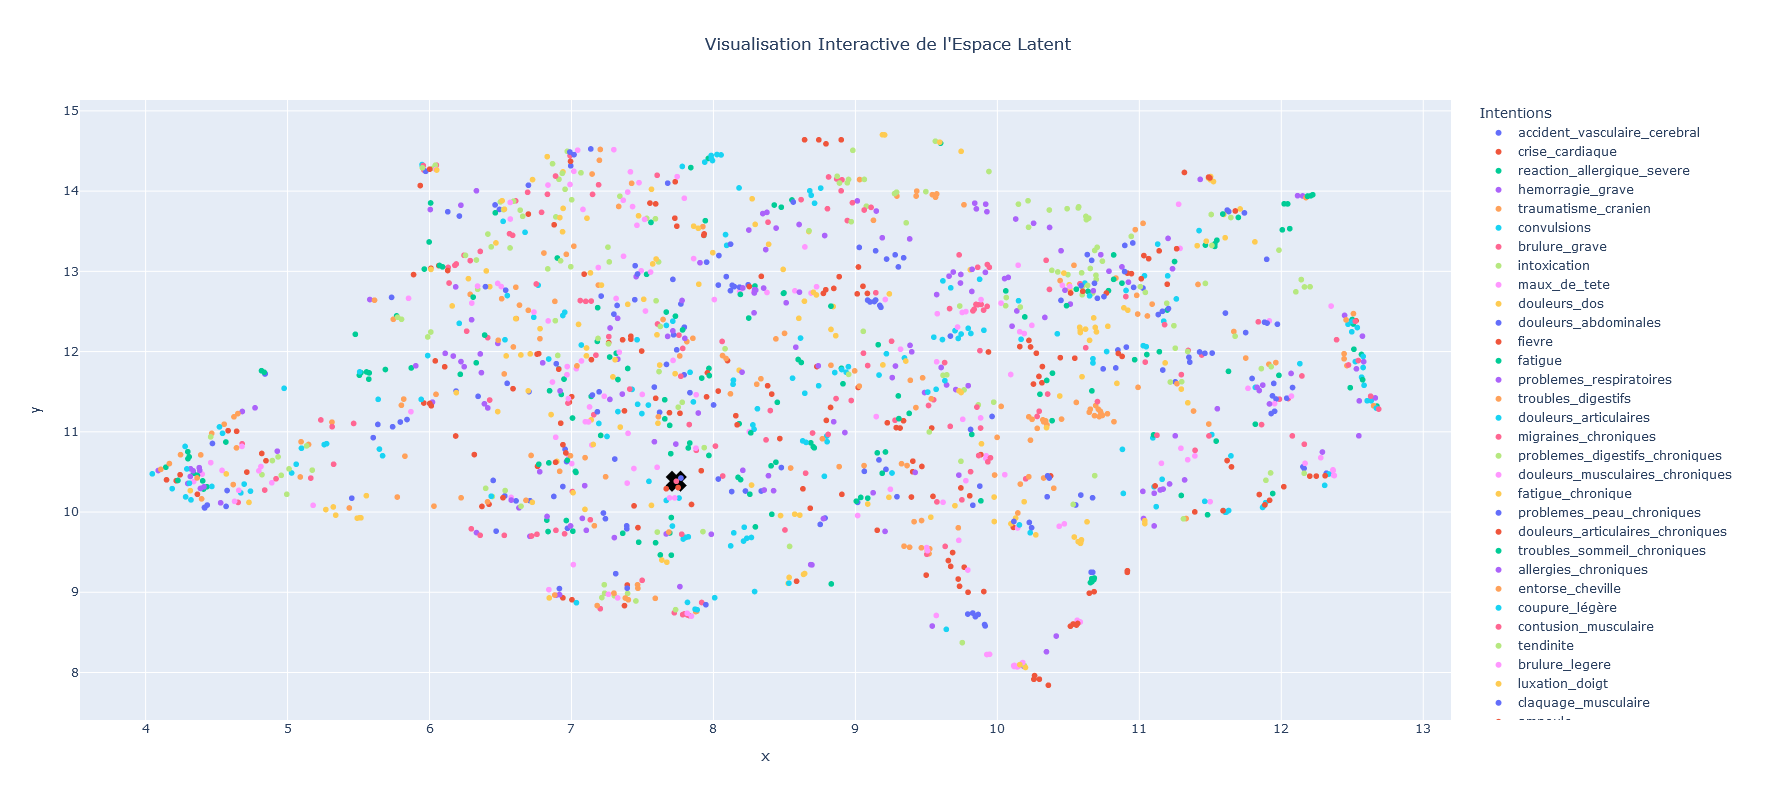


--------------------------------------------------



Vous:  J'ai mal au dos


1/1 [==============================] - 0s 215ms/step

=== Analyse de la requête ===
Top 3 patterns les plus similaires:
- J'ai mal au dos (douleurs_dos) : 0.942
- J'ai mal au ventre (douleurs_abdominales) : 0.483
- J'ai mal au dos, quel spécialiste voir ? (douleurs_articulaires) : 0.329

[Debug] Tag sélectionné: douleurs_dos
[Debug] Confiance: 0.942
[Debug] Méthode: Similarité cosinus (0.94)
[Debug] Pattern correspondant: J'ai mal au dos

Chatbot: Analyse de votre douleur dorsale :

CAUSES FRÉQUENTES:
- Effort/mauvaise posture
- Contracture musculaire
- Hernie discale possible

SOULAGEMENT:
1. Évitez positions douloureuses
2. Chaleur locale
3. Anti-inflammatoires si prescrits

CONSULTEZ SI:
- Douleur irradie jambe
- Perte de force
- Troubles urinaires
- Douleur > 1 semaine


C:\anaconda\envs\DL_S9_2024\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



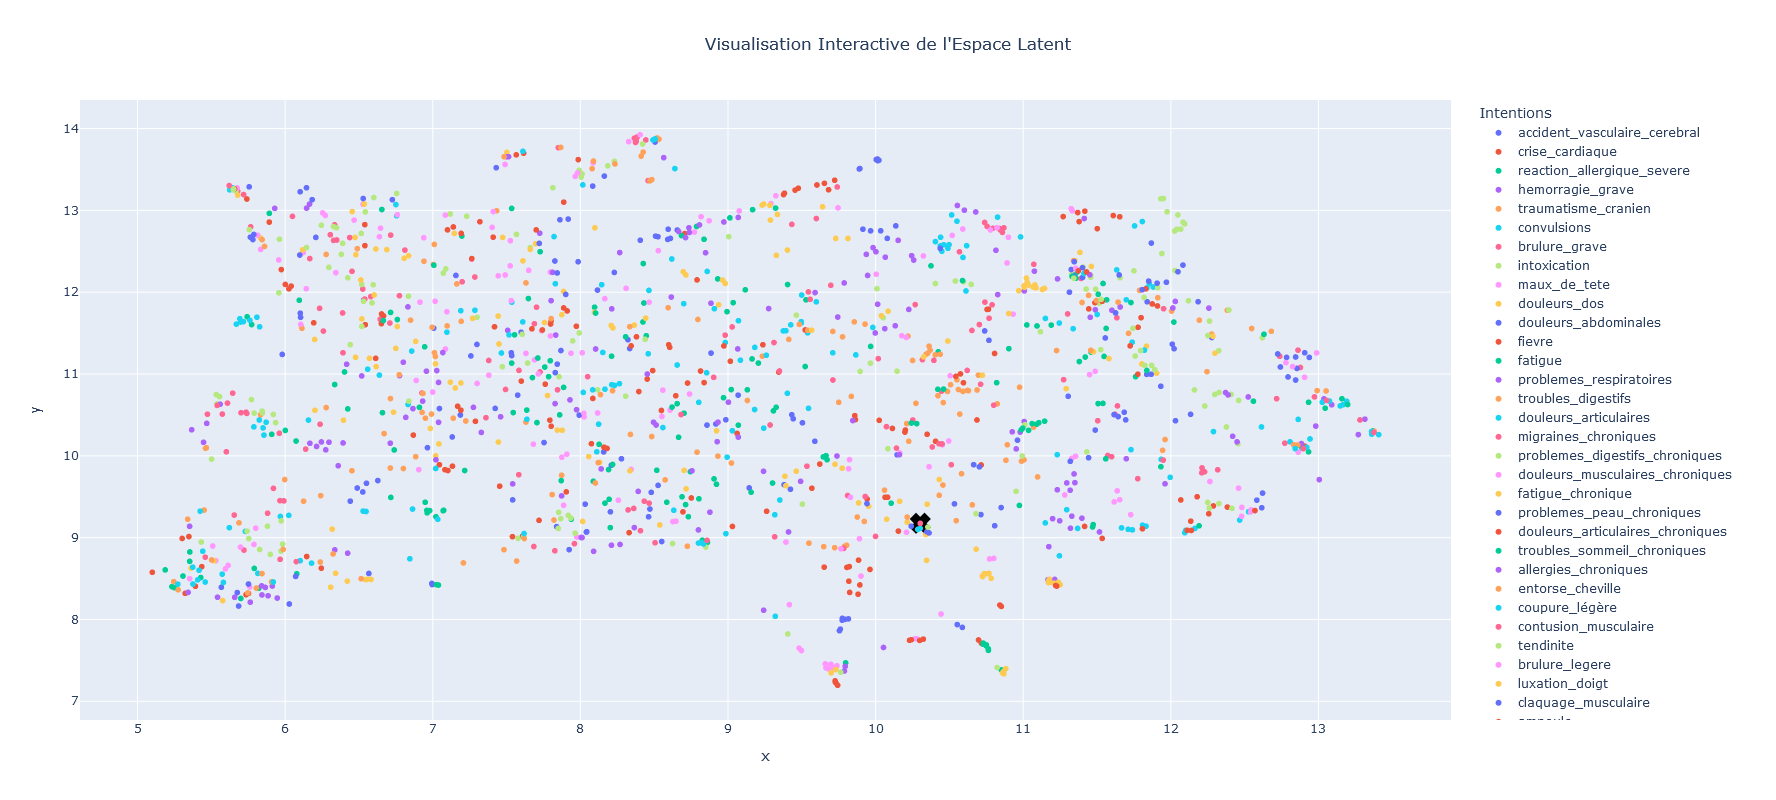


--------------------------------------------------



Vous:  Je me sens seule, je me sens pas bien


1/1 [==============================] - 0s 197ms/step

=== Analyse de la requête ===
Top 3 patterns les plus similaires:
- Je me sens épuisé (fatigue) : 0.386
- Je me sens inutile (perte_sens) : 0.355
- Je me sens abandonné (sentiment_solitude) : 0.355

[Debug] Tag sélectionné: fatigue
[Debug] Confiance: 0.386
[Debug] Méthode: Similarité cosinus faible (0.39)
[Debug] Pattern correspondant: Je me sens épuisé

Chatbot: Analyse de votre fatigue :

CAUSES FRÉQUENTES:
- Manque de sommeil
- Stress/surmenage
- Carence en fer/vitamines
- Maladie virale

RECOMMANDATIONS:
1. Régularisez cycle sommeil
2. Activité physique modérée
3. Alimentation équilibrée

CONSULTEZ SI:
- Fatigue > 3 semaines
- Perte de poids
- Troubles du sommeil
- Déprime associée


C:\anaconda\envs\DL_S9_2024\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



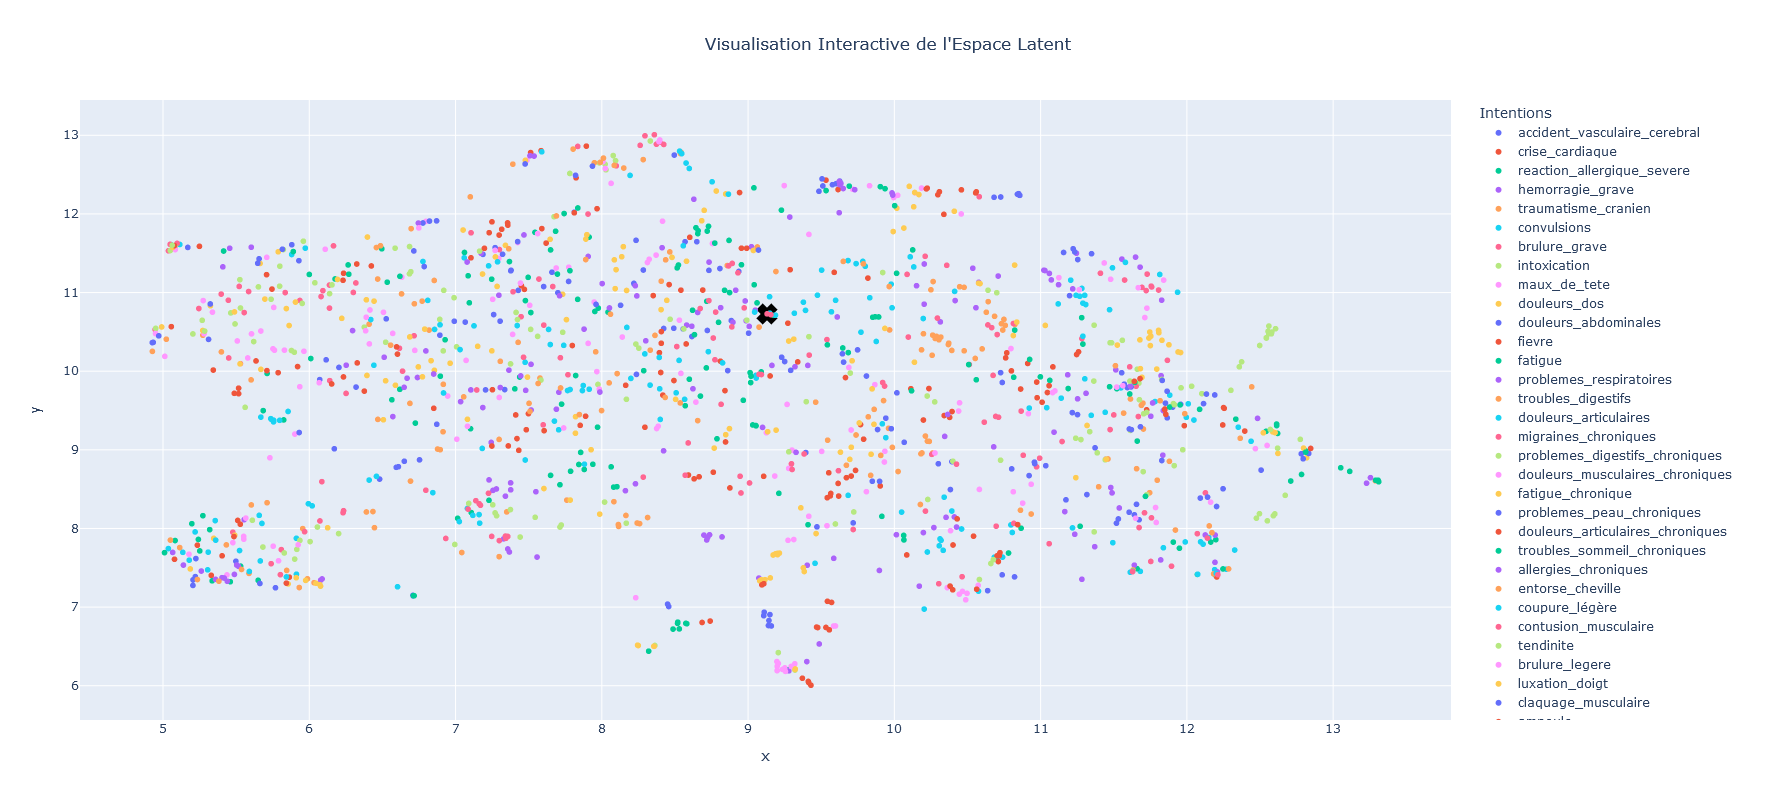


--------------------------------------------------



Vous:  Quelle est la cause de mortalité la plus fréquente en France ?


1/1 [==============================] - 0s 53ms/step

=== Analyse de la requête ===
Top 3 patterns les plus similaires:
- Première cause de mortalité (causes_deces_principales) : 0.424
- Quelle est la tension normale (tension_normale) : 0.333
- Quelle est la meilleure façon de t'utiliser ? (utilisation_koky) : 0.289

[Debug] Tag sélectionné: causes_deces_principales
[Debug] Confiance: 0.424
[Debug] Méthode: Similarité cosinus faible (0.42)
[Debug] Pattern correspondant: Première cause de mortalité

Chatbot: Principales causes de décès en France :

CAUSES MAJEURES :
1. Maladies cardiovasculaires
- 140 000 décès/an
- 25% des décès
- Première cause +65 ans

2. Cancers
- 150 000 décès/an
- 28% des décès
- Première cause < 65 ans

3. Accidents/Suicides
- 40 000 décès/an
- Première cause 15-35 ans

4. Maladies respiratoires
- 35 000 décès/an
- 6% des décès

NOTE : Ces statistiques varient selon
- Âge
- Sexe
- Région
- Mode de vie


C:\anaconda\envs\DL_S9_2024\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



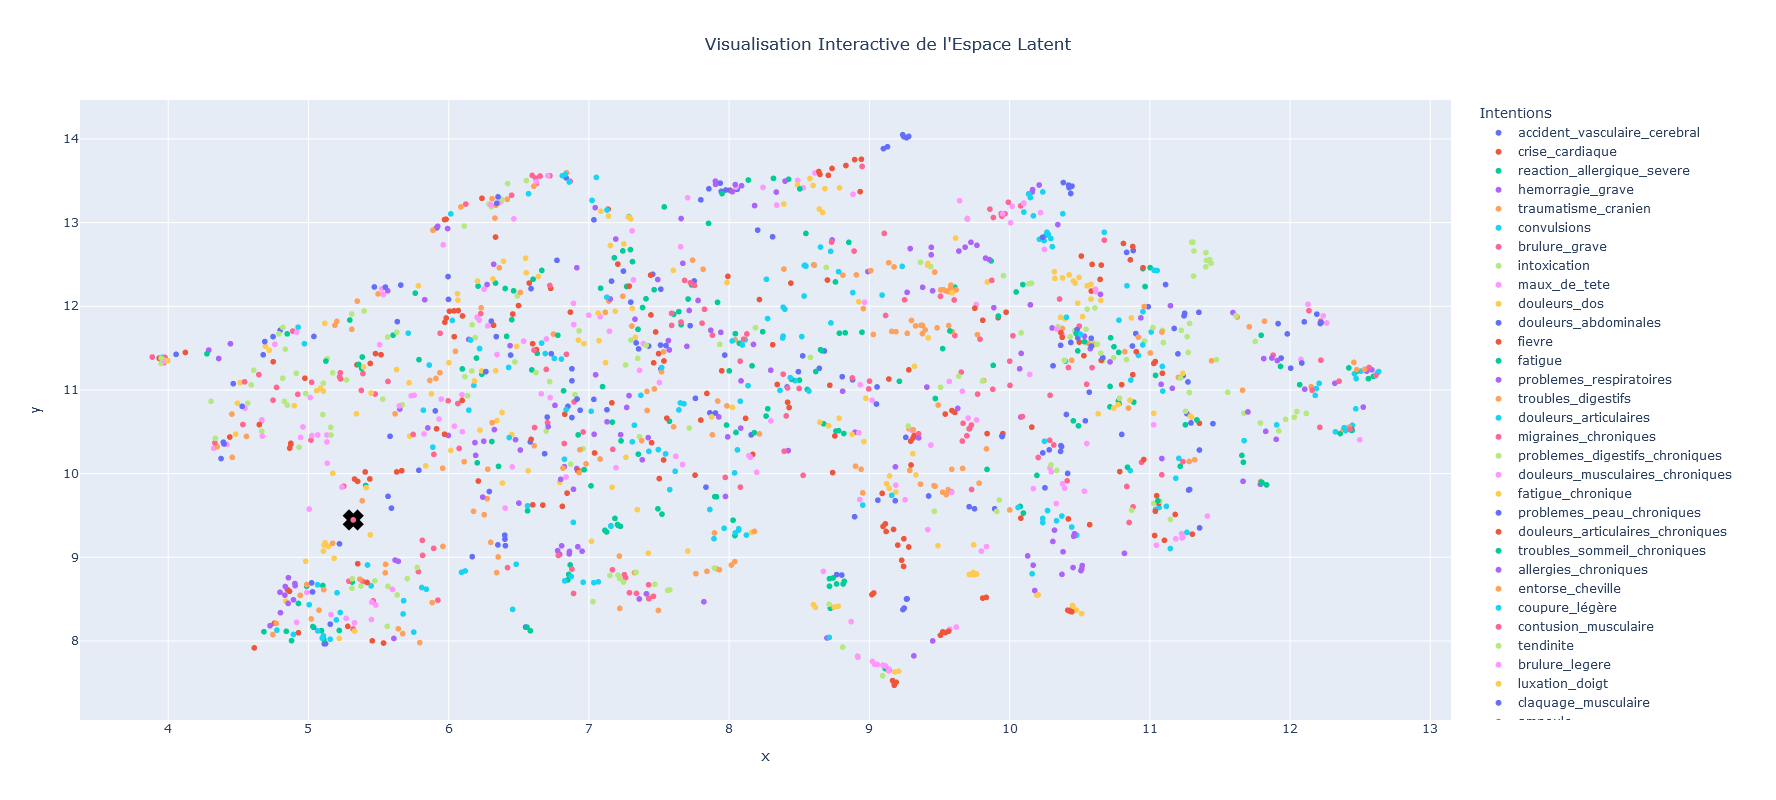


--------------------------------------------------



Vous:  quit


Chatbot: Au revoir !


In [13]:
def chat():
    """Interface de chat interactive avec analyse détaillée"""
    print("Chatbot: Bonjour ! Tapez 'quit' pour arrêter.")
    
    while True:
        query = input("\nVous: ")
        
        if query.lower() == 'quit':
            print("Chatbot: Au revoir !")
            break
        
        # Obtention de la réponse et des métriques
        response, confidence, tag, matched_pattern, method = get_best_response(query)
        
        # Calcul des top 3 similarités
        query_embedding = vectorizer.transform([query]).toarray()
        similarities = np.dot(pattern_embeddings_dense, query_embedding.T).flatten()
        similarities = similarities / (
            np.linalg.norm(pattern_embeddings_dense, axis=1) * 
            np.linalg.norm(query_embedding)
        )
        
        top_indices = np.argsort(similarities)[-3:][::-1]
        
        print("\n=== Analyse de la requête ===")
        print(f"Top 3 patterns les plus similaires:")
        for idx in top_indices:
            print(f"- {patterns[idx]} ({pattern_tags[idx]}) : {similarities[idx]:.3f}")
        
        if tag:
            print(f"\n[Debug] Tag sélectionné: {tag}")
            print(f"[Debug] Confiance: {confidence:.3f}")
            print(f"[Debug] Méthode: {method}")
            if matched_pattern:
                print(f"[Debug] Pattern correspondant: {matched_pattern}")
        
        print(f"\nChatbot: {response}")
        
        # Visualisation
        try:
            visualize_embeddings_interactive(query)
        except Exception as e:
            print(f"Erreur lors de la visualisation: {e}")
        
        print("\n" + "-"*50)

# Lancement du chat interactif
chat()

### 9. Test et Utilisation

Vous pouvez maintenant utiliser le chatbot de plusieurs manières :

1. **Chat Interactif**
```python
chat()  # Lance l'interface interactive complète
```

2. **Requêtes Individuelles**
```python
response, confidence, tag, pattern, method = get_best_response("votre question")
```

3. **Visualisation Spécifique**
```python
visualize_embeddings_interactive("votre question")
```

Le système va :
- Analyser votre requête par deux méthodes
- Choisir la meilleure réponse
- Fournir une explication détaillée
- Visualiser le processus de décision

Les paramètres ajustables principaux sont :
- `similarity_threshold` (0.5) : seuil de similarité cosinus
- Les seuils de confiance dans `get_best_response`
- Les paramètres du réseau de neurones

## 10. Interface Graphique pour le Chatbot Santé

Cette partie implémente une interface graphique moderne et intuitive pour notre chatbot en utilisant Tkinter. Les caractéristiques principales sont :

**Fonctionnalités Clés**
1. **Design Moderne**
   - Messages en style "bulle" comme WhatsApp/Messenger
   - Distinction visuelle entre messages utilisateur et chatbot
   - Thème sombre élégant (#343541) pour les bulles de messages

2. **Ergonomie**
   - Défilement automatique vers les nouveaux messages
   - Zone de saisie avec validation par touche Entrée
   - Scrolling fluide de l'historique des conversations

3. **Architecture**
   - Organisation modulaire avec classe ChatbotGUI
   - Séparation claire entre logique et interface
   - Intégration transparente avec le chatbot existant

4. **Fonctionnalités Avancées**
   - Auto-redimensionnement des bulles de messages
   - Gestion intelligente de l'espace
   - Focus automatique sur la zone de saisie

Le code suivant implémente cette interface graphique :
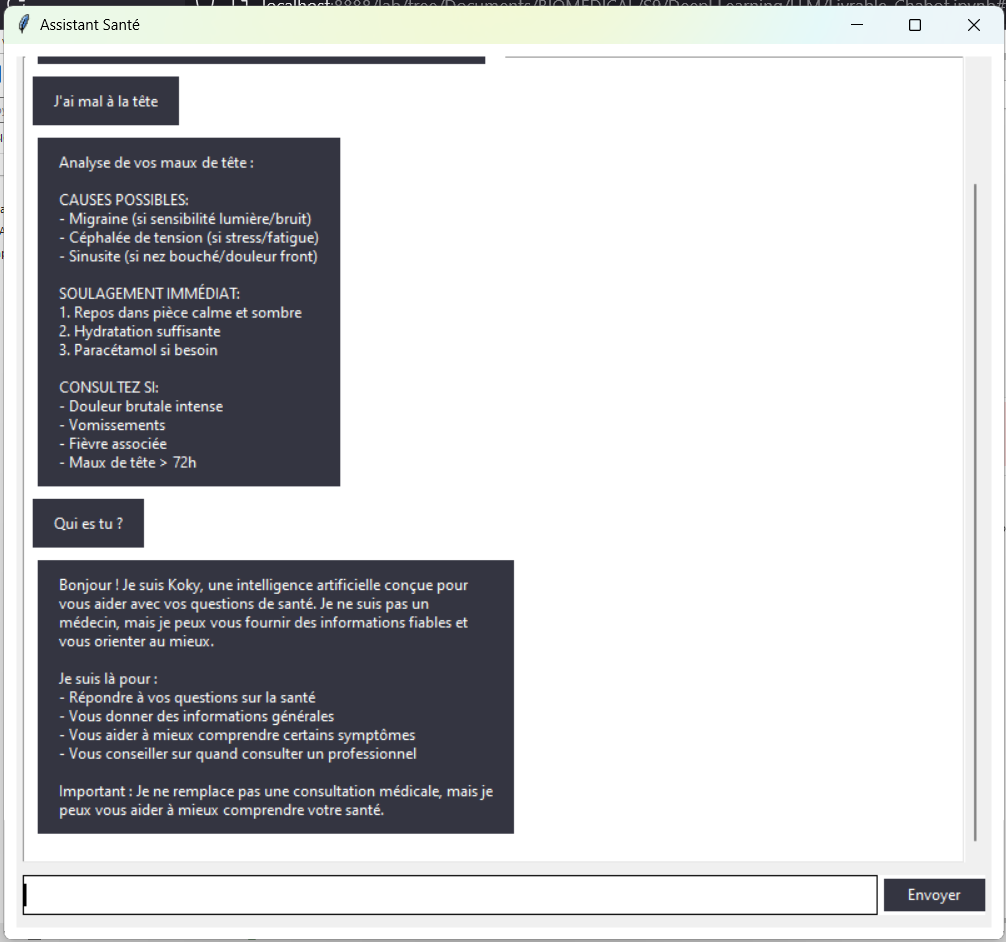

In [15]:
import tkinter as tk
from tkinter import ttk, scrolledtext

class ChatbotGUI:
    def __init__(self, root, chatbot):
        self.root = root
        self.chatbot = chatbot
        self.root.title("Assistant Santé")
        
        self.root.geometry("800x600")
        self.root.configure(bg='white')
        
        self.create_frames()
        self.create_chat_widgets()
        
        self.root.grid_columnconfigure(0, weight=1)
        self.root.grid_rowconfigure(0, weight=1)

    def create_frames(self):
        self.chat_frame = ttk.Frame(self.root)
        self.chat_frame.grid(row=0, column=0, sticky="nsew", padx=10, pady=10)
        self.chat_frame.grid_columnconfigure(0, weight=1)
        self.chat_frame.grid_rowconfigure(0, weight=1)

    def create_message_bubble(self, message, is_user=True):
        bubble_frame = tk.Frame(self.messages_text, bg='white')
        bubble_frame.columnconfigure(1, weight=1)
        
        if is_user:
            bubble = tk.Label(
                bubble_frame,
                text=message,
                bg='#343541',
                fg='white',
                wraplength=350,
                justify="left",
                padx=15,
                pady=10
            )
            tk.Label(bubble_frame, bg='white').grid(row=0, column=0, sticky='ew')
            bubble.grid(row=0, column=1, sticky='e', pady=5, padx=(0, 10))
            bubble_frame.grid_columnconfigure(0, weight=1)
            bubble_frame.grid_columnconfigure(1, weight=0)
            
        else:
            bubble = tk.Label(
                bubble_frame,
                text=message,
                bg='#343541',
                fg='white',
                wraplength=350,
                justify="left",
                padx=15,
                pady=10
            )
            bubble.grid(row=0, column=0, sticky='w', pady=5, padx=10)
            tk.Label(bubble_frame, bg='white').grid(row=0, column=1, sticky='ew')
            bubble_frame.grid_columnconfigure(0, weight=0)
            bubble_frame.grid_columnconfigure(1, weight=1)
            
        return bubble_frame

    def create_chat_widgets(self):
        self.messages_text = scrolledtext.ScrolledText(
            self.chat_frame,
            wrap=tk.WORD,
            bg='white',
            height=20,
            font=('Arial', 10)
        )
        self.messages_text.grid(row=0, column=0, sticky="nsew", padx=5)
        self.messages_text.configure(state='disabled')
        
        input_frame = tk.Frame(self.chat_frame, bg='white')
        input_frame.grid(row=1, column=0, sticky="ew", padx=5, pady=10)
        input_frame.grid_columnconfigure(0, weight=1)
        
        self.chat_input = tk.Entry(
            input_frame,
            font=('Arial', 12),
            bd=1,
            relief="solid"
        )
        self.chat_input.grid(row=0, column=0, sticky="ew", padx=(0, 5), ipady=5)
        self.chat_input.bind("<Return>", self.send_message)
        
        send_button = tk.Button(
            input_frame,
            text="Envoyer",
            bg='#343541',
            fg='white',
            relief="flat",
            command=self.send_message,
            padx=15
        )
        send_button.grid(row=0, column=1)

    def send_message(self, event=None):
        query = self.chat_input.get()
        if not query:
            return
        
        self.chat_input.delete(0, tk.END)
        self.messages_text.configure(state='normal')
        
        user_bubble = self.create_message_bubble(query, is_user=True)
        self.messages_text.window_create(tk.END, window=user_bubble)
        self.messages_text.insert(tk.END, '\n')
        
        response, confidence, tag, matched_pattern, method = self.chatbot.get_best_response(query)
        
        bot_bubble = self.create_message_bubble(response, is_user=False)
        self.messages_text.window_create(tk.END, window=bot_bubble)
        self.messages_text.insert(tk.END, '\n')
        
        self.messages_text.configure(state='disabled')
        self.messages_text.update()
        self.root.after(100, lambda: self.messages_text.see(tk.END))
        self.chat_input.focus()

# Fonction de lancement de l'interface pour n'importe quel chatbot
def launch_chatbot_gui(chatbot_instance):
    root = tk.Tk()
    app = ChatbotGUI(root, chatbot_instance)
    root.mainloop()



# Initialisation du chatbot
data = load_data('data_healthV2.json')
classes = initialize_classes()
embeddings = generate_embeddings()

class ChatbotInstance:
    def __init__(self):
        self.data = data  # utilise la variable globale
        self.model = model  # utilise la variable globale
        self.vectorizer = vectorizer  # utilise la variable globale
        
    def get_best_response(self, query):  # Ajout du paramètre self
        # On utilise les variables de l'instance au lieu des variables globales
        query_embedding = self.vectorizer.transform([query]).toarray()
        similarities = np.dot(pattern_embeddings_dense, query_embedding.T).flatten()
        norm_product = np.linalg.norm(pattern_embeddings_dense, axis=1) * np.linalg.norm(query_embedding)
        
        # Éviter division par zéro
        similarities = np.where(norm_product > 0, similarities / norm_product, 0)
        
        best_match_idx = np.argmax(similarities)
        best_similarity = similarities[best_match_idx]
        best_pattern_tag = pattern_tags[best_match_idx]
                    
        if best_similarity >= 0.1:
            return (
                self.get_response(best_pattern_tag),
                best_similarity,
                best_pattern_tag,
                patterns[best_match_idx],
                f"Similarité ({best_similarity:.2f})"
            )
        
        return (
            "Je ne suis pas sûr de comprendre votre question. Pourriez-vous la reformuler ?",
            0,
            None,
            None,
            "Aucune correspondance trouvée"
        )
        
    def predict_intent(self, query):
        query_embedding = self.vectorizer.transform([query]).toarray()
        prediction = self.model.predict(query_embedding)[0]
        thresh = 0.1
        valid_predictions = [(i, p) for i, p in enumerate(prediction) if p > thresh]
        valid_predictions.sort(key=lambda x: x[1], reverse=True)
        return [(classes[idx], prob) for idx, prob in valid_predictions]
        
    def get_response(self, intent):
        for i in self.data["intents"]:
            if i["tag"] == intent:
                return random.choice(i["responses"])
        return "Désolé, je n'ai pas compris."

# Création de l'instance
chatbot_instance = ChatbotInstance()

# Lancement de l'interface graphique
launch_chatbot_gui(chatbot_instance)

C:\Users\jeane\AppData\Local\Temp\ipykernel_16460\2381554306.py:147: RuntimeWarning:

invalid value encountered in divide



### 11. Conclusion et Perspectives d'Amélioration
Ce projet de chatbot médical démontre l'efficacité d'une approche hybride combinant apprentissage profond et similarité textuelle. Les résultats obtenus, bien qu'encourageants, révèlent plusieurs axes d'amélioration potentiels.
#### Résultats Actuels

**Performance**

- Validation accuracy ~40% sur 136 classes
- Bonne capacité de généralisation relative au volume de données
- Réponses pertinentes via similarité cosinus pour les requêtes proches


**Points Forts**

- Architecture simple et robuste
- Forte régularisation adaptée au petit jeu de données
- Interface graphique intuitive et professionnelle



#### Axes d'Amélioration

**Données**

- Augmenter le volume de données d'entraînement
- Enrichir les patterns avec des variations linguistiques
- Équilibrer la distribution des classes
- Ajouter des données réelles de conversations patient-médecin


**Architecture**

- Expérimenter avec des modèles de langage pré-entraînés (BERT, CamemBERT)
- Implémenter un système de mémoire pour le contexte conversationnel
- Ajouter des connexions résiduelles si plus de données disponibles
- Intégrer un système de détection d'urgence médicale


**Fonctionnalités**

- Ajouter un système de suivi de contexte
- Implémenter une hiérarchie de réponses selon la gravité
- Intégrer des sources médicales externes
- Ajouter des visualisations explicatives pour les réponses


**Évaluation et Sécurité**

- Mettre en place des tests systématiques avec des professionnels de santé
- Ajouter des disclaimers médicaux appropriés
- Développer des métriques d'évaluation spécifiques au domaine médical
- Implémenter un système de feedback utilisateur


**Technique**

- Optimiser la vectorisation des textes (Word2Vec, FastText)
- Améliorer la gestion des requêtes hors domaine
- Implementer du data augmentation pour les classes sous-représentées
- Ajouter de la validation croisée pour une évaluation plus robuste



Ce projet constitue une base solide pour un assistant médical, mais nécessite des améliorations significatives avant une utilisation en production, particulièrement en termes de volume de données et de validation médicale.